# Machine Learning LAB 2: SUPPORT VECTOR MACHINES

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks to be performed with **SUPPORT VECTOR MACHINES (SVM)**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Weather Classification with Support Vector Machines

In this notebook we are going to explore the use of Support Vector Machines (SVM) for weather classification. We will use a dataset collected using the Luxottica **iSee** glasses. These devices provide multiple **sensors mounted inside the glasses**, which can be accessed through a bluetooth connection.

![I-SEE Glasses](data/isee.png "I-SEE")

The dataset corresponds to 8 hours of atmospherical data recordings sampled every 3 seconds.

The dataset labels are the following:

| ID  | Label       |
| :-: | :-:         |
| 0   | Sunny       |
| 1   | Rain        |
| 2   | Cloudy      |
| 3   | Mostly Clear|

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB02.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Dario Liotta

**ID Number**: 2124229

---

## Import all the necessary Python libraries

In [38]:
%matplotlib inline

import numpy as np
import scipy as sp
import itertools
from matplotlib import pyplot as plt

import sklearn.metrics as skm
from sklearn.svm import SVC
from sklearn import linear_model

---

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `load_dataset` -> to load the dataset from the file `data/lux.npz`,
2. `plot_input` -> to plot the input data,
3. `k_split` ->  to split the trainig dataset in k different folds,
4. `k_fold_cross_validation` -> to perform the k-fold cross validation.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
# Helper function to load the dataset
def load_dataset(path: str) -> (np.ndarray, np.ndarray):
    with np.load(path) as data:
        x, y = data["x"], data["y"]
        
        # Normalize the data
        x -= x.mean(axis=0)
        x /= x.std(axis=0)
        
    return x, y

In [3]:
# Function for plotting a image and printing the corresponding label
def plot_input(X_matrix: np.ndarray, labels: np.ndarray) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    cmap = plt.cm.get_cmap('Accent', 4)
    im = ax.scatter(X_matrix[:,0], X_matrix[:,1], X_matrix[:,2], c=labels, cmap=cmap)
    im.set_clim(-0.5, 3.5)
    cbar=fig.colorbar(im, ticks=[0,1,2,3], orientation='vertical', cmap=cmap)
    cbar.ax.set_yticklabels(['Sunny', 'Rainy','Cloudy', 'Mostly clear']) 

In [4]:
# Function to split the dataset in k different folds
def k_split(x: np.ndarray, y:np.ndarray, k: int, shuffle: bool = True) -> tuple[list[np.ndarray], list[np.ndarray]]:
    # Shuffle the dataset
    if shuffle:
        # Create a list of indices
        idx = np.arange(x.shape[0])
        # Randomly shuffle the indices
        np.random.shuffle(idx)
        # Shuffle the dataset
        x = x[idx]
        y = y[idx]

    # Split the dataset in k folds
    s = x.shape[0] // k
    indexes = [i * s for i in range(k+1)]
    
    x_folds = [x[indexes[i] : indexes[i + 1]] for i in range(k)]
    y_folds = [y[indexes[i] : indexes[i + 1]] for i in range(k)]
    
    return x_folds, y_folds

In [5]:
# Function to perform the k-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, model: SVC, parameters: dict) -> tuple[tuple, tuple]:
    # Define the folds for the cross validation
    x_folds, y_folds = k_split(x_train, y_train, k)

    # Build a list containing all of the possible combinatioon of parameters
    params = list(itertools.product(*parameters.values()))

    # Initialize the dictionary of results
    results = {k: 0 for k in params}

    # For each param combination, perform the SVM training and testing
    for param in params:
        param = dict(zip(parameters.keys(), param))

        fold_accuracies = []
        
        for i in range(k):
            x_test, y_test = x_folds[i], y_folds[i]
            
            x_training = x_folds[:i] + x_folds[i+1:]
            x_training = np.concatenate(x_training[:])
            y_training = y_folds[:i] + y_folds[i+1:]
            y_training = np.concatenate(y_training[:])
            
            model.set_params(**param)
            model.fit(x_training, y_training)
            accuracy = model.score(x_test, y_test)
            fold_accuracies.append(accuracy)

        # Compute the mean accuracy
        results[tuple(param.values())] = round(np.mean(fold_accuracies), 4)
    
    # Find the best parameters
    best_parameters = dict(zip(parameters.keys(), params[np.argmax(list(results.values()))]))
    best_accuracy = np.max(list(results.values()))
    best = (best_parameters, best_accuracy)

    # Add the param name to the results
    results = [({k: v for k, v in zip(parameters.keys(), p)}, a) for p, a in results.items()]

    return best, results

---

## A) Hyper-parameter search

### TO DO (A.0)

**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [58]:
# fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2124229
np.random.seed(ID)

Before proceding to the training steps, we **load the dataset and split it** in training and test set (while the **training** set is **typically larger**, here we set the number of training samples to 1000 and 4000 for the test data).
The **split** is **performed after applying a random permutation** to the dataset, such permutation will **depend on the seed** you set above.

In [59]:
# Load the dataset using the helper function
X, y = load_dataset("data/lux.npz")
print(X.shape, y.shape)

(15099, 3) (15099,)


In [60]:
# The task is quite easy, let's add noise to make it more challenging!
# You can try without noise (comment the next 2 lines, easy task), with the suggested amount of noise,
# or play with the suggested amount of noise 

noise = np.random.normal(0, 0.1, X.shape)
X = X + noise

### TO DO (A.1)

**Divide** the **data into training and test set** (for this part use 1000 samples in the **first** set, 4000 in the **second** one). Make sure that each label is present at least 10 times in training. If it is not, then keep adding permutations to the initial data until this happens.


In [61]:
# Random permute the data and split into training and test taking the first 1000
# data samples as training and 4000 samples as test
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 1000
m_test = 4000

X_train = X[:m_training]
X_test = X[m_training : m_training + m_test]
y_train = y[:m_training]
y_test = y[m_training : m_training + m_test]

print("X_train shape:", X_train.shape,"X_test shape:", X_test.shape,"||","y_train shape:",  y_train.shape,"y_test shape:", y_test.shape)

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

X_train shape: (1000, 3) X_test shape: (4000, 3) || y_train shape: (1000,) y_test shape: (4000,)
Labels in training dataset:  [0. 1. 2. 3.]
Frequencies in training dataset:  [385 167 389  59]


/var/folders/89/_448p9dn6rz8_6mwnlv3tccm0000gn/T/ipykernel_1616/31676135.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Accent', 4)


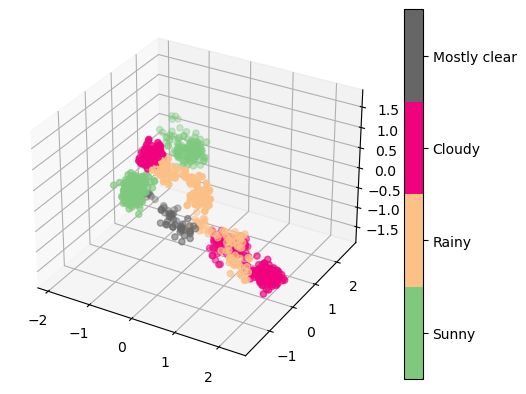

In [62]:
#Let's try the plotting function
plot_input(X_train,y_train)

### TO DO (A.2)

Use a SVM classfier with cross validation to pick a model. Use a 4-fold cross-validation. Let's start with a Linear kernel.

In [63]:
# Parameters for linear SVM
parameters = {'C': [ 0.01, 0.1, 1, 10]}

# Define the model (without parameters)
svm = SVC(kernel = 'linear')

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, 4, svm, parameters)

print ('RESULTS FOR LINEAR KERNEL')

print("Best parameter set found:")
print(best[0])

print("Score with best parameter:")
print(best[1])
print()
print("All scores on the grid:")
print(results)

RESULTS FOR LINEAR KERNEL
Best parameter set found:
{'C': 10}
Score with best parameter:
0.897

All scores on the grid:
[({'C': 0.01}, 0.773), ({'C': 0.1}, 0.851), ({'C': 1}, 0.895), ({'C': 10}, 0.897)]


### TO DO (A.3)

Pick a model for the Polynomial kernel with degree=2.

In [64]:
# Parameters for linear SVM
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1,1.]}

# Define an SVM with poly of degree 2 kernel (without parameters)
poly2_svm = SVC(kernel = 'poly', degree = 2)

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, 4, poly2_svm, parameters)

print ('RESULTS FOR POLY DEGREE=2 KERNEL')

print("Best parameter set found:")
print(best[0])

print("Score with best parameter:")
print(best[1])
print()
print("All scores on the grid:")
print(results)

RESULTS FOR POLY DEGREE=2 KERNEL
Best parameter set found:
{'C': 1, 'gamma': 1.0}
Score with best parameter:
0.951

All scores on the grid:
[({'C': 0.01, 'gamma': 0.01}, 0.363), ({'C': 0.01, 'gamma': 0.1}, 0.363), ({'C': 0.01, 'gamma': 1.0}, 0.85), ({'C': 0.1, 'gamma': 0.01}, 0.363), ({'C': 0.1, 'gamma': 0.1}, 0.774), ({'C': 0.1, 'gamma': 1.0}, 0.933), ({'C': 1, 'gamma': 0.01}, 0.363), ({'C': 1, 'gamma': 0.1}, 0.85), ({'C': 1, 'gamma': 1.0}, 0.951)]


### TO DO (A.4)

Now let's try a higher degree for the polynomial kernel (e.g., 3rd degree).

In [65]:
# Parameters for poly with higher degree kernel
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1, 1]}

# Define an SVM with poly of higher degree kernel (without parameters)
degree = 3
poly_svm = SVC(kernel = 'poly', degree = degree)

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, 4, poly_svm, parameters)

print (f"RESULTS FOR POLY DEGREE={degree} KERNEL")

print("Best parameter set found:")
print(best[0])

print("Score with best parameter:")
print(best[1])
print()
print("All scores on the grid:")
print(results)

RESULTS FOR POLY DEGREE=3 KERNEL
Best parameter set found:
{'C': 1, 'gamma': 1}
Score with best parameter:
0.929

All scores on the grid:
[({'C': 0.01, 'gamma': 0.01}, 0.407), ({'C': 0.01, 'gamma': 0.1}, 0.407), ({'C': 0.01, 'gamma': 1}, 0.839), ({'C': 0.1, 'gamma': 0.01}, 0.407), ({'C': 0.1, 'gamma': 0.1}, 0.536), ({'C': 0.1, 'gamma': 1}, 0.903), ({'C': 1, 'gamma': 0.01}, 0.407), ({'C': 1, 'gamma': 0.1}, 0.773), ({'C': 1, 'gamma': 1}, 0.929)]


### TO DO (A.5)

Pick a model for the Radial Basis Function kernel:

In [66]:
# Parameters for rbf SVM
parameters = {'C': [0.1, 1, 10, 100],'gamma':[0.001, 0.01, 0.1,1]}

# Define an SVM with rbf kernel (without parameters)
rbf_svm = SVC(kernel = 'rbf')

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, 4, rbf_svm, parameters)

print ('RESULTS FOR rbf KERNEL')

print("Best parameter set found:")
print(best[0])

print("Score with best parameter:")
print(best[1])
print()
print("All scores on the grid:")
print(results)

RESULTS FOR rbf KERNEL
Best parameter set found:
{'C': 10, 'gamma': 1}
Score with best parameter:
0.992

All scores on the grid:
[({'C': 0.1, 'gamma': 0.001}, 0.378), ({'C': 0.1, 'gamma': 0.01}, 0.606), ({'C': 0.1, 'gamma': 0.1}, 0.828), ({'C': 0.1, 'gamma': 1}, 0.942), ({'C': 1, 'gamma': 0.001}, 0.605), ({'C': 1, 'gamma': 0.01}, 0.773), ({'C': 1, 'gamma': 0.1}, 0.94), ({'C': 1, 'gamma': 1}, 0.987), ({'C': 10, 'gamma': 0.001}, 0.772), ({'C': 10, 'gamma': 0.01}, 0.886), ({'C': 10, 'gamma': 0.1}, 0.982), ({'C': 10, 'gamma': 1}, 0.992), ({'C': 100, 'gamma': 0.001}, 0.88), ({'C': 100, 'gamma': 0.01}, 0.969), ({'C': 100, 'gamma': 0.1}, 0.99), ({'C': 100, 'gamma': 1}, 0.992)]


### TO DO (A.Q1) [Answer the following]

What do you observe when using RBF and polynomial kernels on this dataset ?

**ANSWER A.Q1:**: I've got the following results:

<center>
<div style="margin-bottom: 20px;">

| Kernel          | Accuracy  |
| :-:             | :-:       |
| Linear          | $0.897$   |
| Polynomial (2)  | $0.951$   |
| Polynomial (3)  | $0.929$   |
| RBF             | $0.992$   |

</div>
<div style="text-align: left;">

So the RBF kernel seems to be better suited for the dataset with respect to polynomial kernels.

We also notice that the polynomial of degree two has a highest accuracy than the polynomial of degree three. Increasing the degree results in the following:

<center>
<div style="margin-bottom: 20px;">

| Kernel          | Accuracy  |
| :-:             | :-:       |
| Polynomial (4)  | $0.971$   |
| Polynomial (5)  | $0.931$   |
| Polynomial (6)  | $0.966$   |
| Polynomial (7)  | $0.943$   |
| Polynomial (8)  | $0.959$   |

</div>
<div style="text-align: left;">

So in general even-degree polynomials appear to fit better the data than odd-degree ones; furthermore, the more the degree become bigger, the more the accuracy decreases, probably due to overfitting reasons.

### TO DO (A.6)
Report here the best SVM kernel and parameters

In [67]:
# Get training and test error for the best SVM model from CV
best_svm = SVC(kernel = 'rbf', C = 10, gamma = 1)

# Run the svm model on the whole training set
best_svm.fit(X_train, y_train)

# Compute the errors
# (error is 1 - svm.score)
training_error = 1 - best_svm.score(X_train, y_train)
test_error = 1-best_svm.score(X_test, y_test)

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

Best SVM training error: 0.007000
Best SVM test error: 0.012250


### TO DO (A.7)

Analyze how the gamma parameter (inversely proportional to standard deviation of Gaussian Kernel) impact the performances of the classifier

In [69]:
# Test with different values of gamma
# use rbf kernel and C=1

# Set gamma values
gamma_values = np.logspace(-5,2,8)
print(gamma_values)

[  0.     0.     0.     0.01   0.1    1.    10.   100.  ]


In [70]:
train_acc_list, test_acc_list = [], []

# ADD YOUR CODE TO TRAIN THE SVM MULTIPLE TIMES WITH THE DIFFERENT VALUES OF GAMMA
# PLACE THE TRAIN AND TEST ACCURACY FOR EACH TEST IN THE TRAIN AND TEST ACCURACY LISTS
for gamma in gamma_values:
    svm_gamma = SVC(kernel = 'rbf', C = 1, gamma = gamma)
    svm_gamma.fit(X_train, y_train)
    
    accuracy_train = svm_gamma.score(X_train, y_train)
    accuracy_test = svm_gamma.score(X_test, y_test)
    train_acc_list.append(accuracy_train)
    test_acc_list.append(accuracy_test)

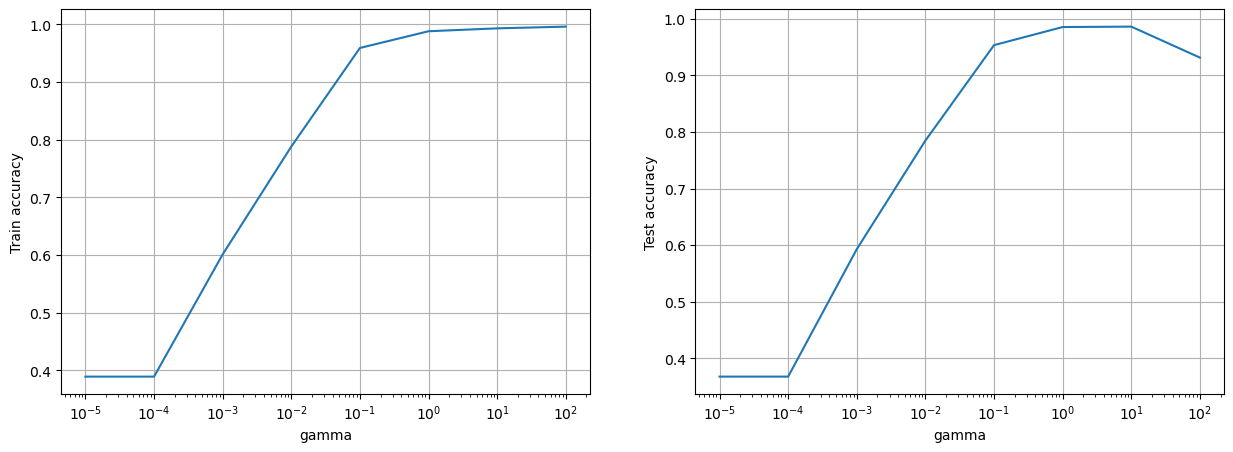

In [71]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(gamma_values, train_acc_list)
ax[0].set_xscale('log')
ax[0].set_xlabel('gamma')
ax[0].set_ylabel('Train accuracy')
ax[0].grid(True)

ax[1].plot(gamma_values, test_acc_list)
ax[1].set_xscale('log')
ax[1].set_xlabel('gamma')
ax[1].set_ylabel('Test accuracy')
ax[1].grid(True)

plt.show()

## B) More data
Now let's do the same but using more data points for training.

### TO DO (B.0)

Choose a higher number of data points (e.g. x = 10000) for training data depending on your computing capability.

In [72]:
X = X[permutation]
y = y[permutation]

m_training = 10000

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts = True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

# initialize support variables for boundaries visualization
granularity = 25
x_max = np.abs(X).max()
x_range = np.linspace(-x_max, x_max, granularity)
x_grid = np.stack(np.meshgrid(x_range, x_range, x_range)).reshape(3, -1).T

Labels in training dataset:  [0. 1. 2. 3.]
Frequencies in training dataset:  [4081 1687 3609  623]


### TO DO (B.1)

Let's try to use SVM with parameters obtained from the best model for $m_{training} =  10000$. Since it may take a long time to run, you can decide to just let it run for some time and stop it if it does not complete. If you decide to do this, report it in the TO DO (C.Q1) cell below.

In [73]:
# Get training and test error for the best SVM model from CV
best_svm = SVC(kernel = 'rbf', C = 10, gamma = 1)

# Run the svm model on the whole training set
best_svm.fit(X_train, y_train)

# Compute the errors
# (error is 1 - svm.score)
training_error = 1 - best_svm.score(X_train, y_train)
test_error = 1-best_svm.score(X_test, y_test)

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

#Poly2
poly2_svm = SVC(kernel = 'poly', degree = 2, C = 1, gamma = 1)
poly2_svm.fit(X_train, y_train)
training_error = 1 - poly2_svm.score(X_train, y_train)
test_error = 1-poly2_svm.score(X_test, y_test)

print ("Polynomial (2) SVM training error: %f" % training_error)
print ("Polynomial (2) SVM test error: %f" % test_error)

#Poly3
poly3_svm = SVC(kernel = 'poly', degree = 3, C = 1, gamma = 1)
poly3_svm.fit(X_train, y_train)
training_error = 1 - poly3_svm.score(X_train, y_train)
test_error = 1-poly3_svm.score(X_test, y_test)

print ("Polynomial (3) SVM training error: %f" % training_error)
print ("Polynomial (3) SVM test error: %f" % test_error)

Best SVM training error: 0.011100
Best SVM test error: 0.011375
Polynomial (2) SVM training error: 0.052300
Polynomial (2) SVM test error: 0.054717
Polynomial (3) SVM training error: 0.068300
Polynomial (3) SVM test error: 0.061973


## C) Boundaries Visualization

Now let us plot the classification boundaries. 

### TO DO (C.0)

Use the SVM to predict on the test set X_test. 

In [74]:
rbf_svm_test =  best_svm.predict(X_test)
poly2_svm_test = poly2_svm.predict(X_test)
poly3_svm_test = poly3_svm.predict(X_test)

We constructed a grid of all possible combinations of input values, we now use it to extract the classification boundaries of the three classifiers by having them predict on each input.

(-2.6270976589551975, 2.6270976589551975)

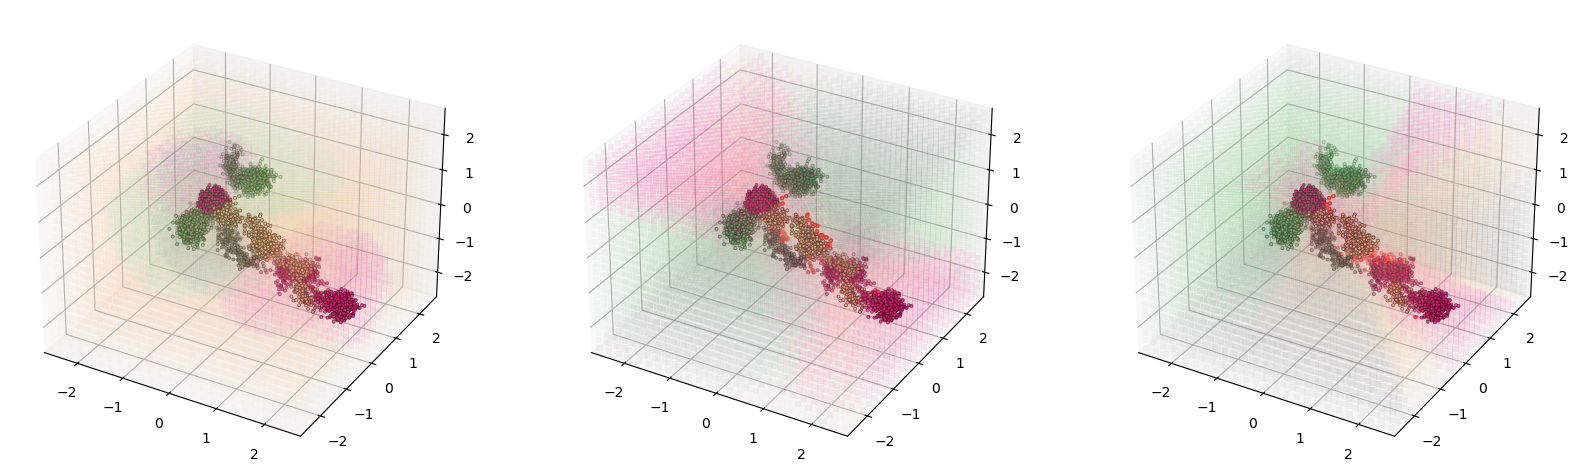

In [75]:
rbf_SVM_grid = rbf_svm.predict(x_grid)
poly2_SVM_grid = poly2_svm.predict(x_grid)
poly3_SVM_grid = poly3_svm.predict(x_grid)

rbf_SVM_m = y_test == rbf_svm_test
poly2_SVM_m = y_test == poly2_svm_test
poly3_SVM_m = y_test == poly3_svm_test

fig = plt.figure(figsize=(20,36))
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection="3d")

ax1.scatter(x_grid[:,0], x_grid[:,1], x_grid[:,2], c=rbf_SVM_grid, linewidth=0, marker="s", alpha=.05,cmap='Accent')
ax2.scatter(x_grid[:,0], x_grid[:,1], x_grid[:,2], c=poly2_SVM_grid, linewidth=0, marker="s", alpha=.05,cmap='Accent')
ax3.scatter(x_grid[:,0], x_grid[:,1], x_grid[:,2], c=poly3_SVM_grid, linewidth=0, marker="s", alpha=.05,cmap='Accent')

ax1.scatter(X_test[rbf_SVM_m,0], X_test[rbf_SVM_m,1], X_test[rbf_SVM_m,2], c=y_test[rbf_SVM_m], linewidth=.5, edgecolor="k", marker=".",cmap='Accent')
ax1.scatter(X_test[~rbf_SVM_m,0], X_test[~rbf_SVM_m,1], X_test[~rbf_SVM_m,2], c=y_test[~rbf_SVM_m], linewidth=1, edgecolor="r", marker=".",cmap='Accent')
ax1.set_xlim([-x_max, x_max])
ax1.set_ylim([-x_max, x_max])
ax1.set_zlim([-x_max, x_max])

ax2.scatter(X_test[poly2_SVM_m,0], X_test[poly2_SVM_m,1], X_test[poly2_SVM_m,2], c=y_test[poly2_SVM_m], linewidth=.5, edgecolor="k", marker=".",cmap='Accent')
ax2.scatter(X_test[~poly2_SVM_m,0], X_test[~poly2_SVM_m,1], X_test[~poly2_SVM_m,2], c=y_test[~poly2_SVM_m], linewidth=1, edgecolor="r", marker=".",cmap='Accent')
ax2.set_xlim([-x_max, x_max])
ax2.set_ylim([-x_max, x_max])
ax2.set_zlim([-x_max, x_max])

ax3.scatter(X_test[poly3_SVM_m,0], X_test[poly3_SVM_m,1], X_test[poly3_SVM_m,2], c=y_test[poly3_SVM_m], linewidth=.5, edgecolor="k", marker=".",cmap='Accent')
ax3.scatter(X_test[~poly3_SVM_m,0], X_test[~poly3_SVM_m,1], X_test[~poly3_SVM_m,2], c=y_test[~poly3_SVM_m], linewidth=1, edgecolor="r", marker=".",cmap='Accent')
ax3.set_xlim([-x_max, x_max])
ax3.set_ylim([-x_max, x_max])
ax3.set_zlim([-x_max, x_max])

### TO DO (C.Q1) [Answer the following]**

Compare and discuss the results from SVM with m=600 and with m=10000 (or whatever value you set) training data points. If you stopped the SVM, include such aspect in your comparison.

**ANSWER C.Q1:** Considering the best results obtained with the RBF kernel I've got the following errors:

<center>
<div style="margin-bottom: 20px;">

|   &nbsp;           | $m = 1000$   | $m = 10000$  |
|   :-:              | :-:          | :-:          |
| **Training error** | $0.007000$   | $0.011100$   |
| **Test error**     | $0.012250$   | $0.011375$   |

</div>
<div style="text-align: left;">

So we can see that the results are similar. One possible reason for this is the already good rapresentativity of the 1000 samples, so that increasing the sample size doesn't lead to substantial improvements of the model performance.

### TO DO (C.1)

Plot the confusion matrix for the SVM classifier. The confusion matrix has one column for each predicted label and one row for each true label. 
It shows for each class in the corresponding row how many samples belonging to that class gets each possible output label. Notice that the diagonal contains the correctly classified samples, while the other cells correspond to errors. You can obtain it with the sklearn.metrics.confusion_matrix function (see the documentation). You can also print also the normalized confusion matrix.


In [76]:
np.set_printoptions(precision=2, suppress=True) # for better aligned printing of confusion matrix use floatmode='fixed'

u, counts = np.unique(y_test, return_counts=True)
print("Labels and frequencies in test set: ", counts)

confusion_SVM =  skm.confusion_matrix(y_test, rbf_svm_test)
print("\n Confusion matrix SVM  \n \n", confusion_SVM)
print("\n Confusion matrix SVM (normalized)   \n \n", confusion_SVM /counts[:,None] )

Labels and frequencies in test set:  [2037  841 1914  307]

 Confusion matrix SVM  
 
 [[2037    0    0    0]
 [   0  810   31    0]
 [   0   26 1887    1]
 [   0    0    0  307]]

 Confusion matrix SVM (normalized)   
 
 [[1.   0.   0.   0.  ]
 [0.   0.96 0.04 0.  ]
 [0.   0.01 0.99 0.  ]
 [0.   0.   0.   1.  ]]


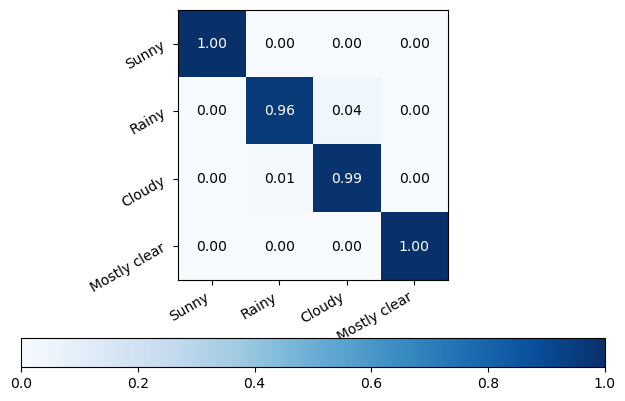

In [77]:
fig = plt.figure()
    
im = plt.imshow(confusion_SVM /counts[:,None], cmap="Blues",interpolation='nearest')
plt.xticks([0,1,2,3], ['Sunny', 'Rainy','Cloudy', 'Mostly clear'],ha="right",rotation=30)
plt.yticks([0,1,2,3], ['Sunny', 'Rainy','Cloudy', 'Mostly clear'],ha="right",rotation=30)
cm = confusion_SVM /counts[:,None]
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(im, location='bottom')  
plt.show()

### TO DO (C.Q2) [Answer the following]

Have a look at the confusion matrix and comment on the obtained accuracies. Why some classes have lower accuracies and others an higher one? Make some guesses on the possible causes.

**ANSWER C.Q2:** We can se that "Sunny" and "Mostly Clear" are always right classified, while "Rainy" and "Cloudy" have some few missclassified points. This is probably due to the fact that Rainy and Cloudy points are really close to each other, because at some point they kind of share the same region (at one end of the "Rainy strip" in the plot).